In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gzip
import glob

The models that were selected were LSTM and CNN-LSTM, as LSTM is suitable for time-series data, whereas CNN-LSTM combines convolutional layers for feature extraction and LSTM layers for sequence prediction. The layout of the notebook is the data and then the models.

# 1. Data

This data has been derived from the sunshine and radiation `kis_tos_202403.gz` dataset from [KNMI][1], which has measurements of average solar irradiance (_Q_) and sunshine duration (_SQ_) for 10 minute intervals for the whole month of March 2024. The data from the original dataset was preprocessed and saved. The preprocessing included removing night values to enhance the performance of the prediction process since only useful data is fed to the model [Alzahrani _et al._ 2017][2].

[1]: https://dataplatform.knmi.nl/dataset/zonneschijnduur-en-straling-1-0
[2]: https://www.sciencedirect.com/science/article/pii/S1877050917318392

This LSTM is trained on data from one specific weather station, given that otherwise we would have multiple data points of the same variable at the same timestamp. The code below shows how was the csv file constructed from the dataframe that was got from KNMI website. The same code for getting the usable dataset could be used on any other weather station from the same original big dataset with multiple weather stations over one month (given that there are no missing values). In case there are null values present in the data that is wished to be trained on, the imputation should be done by interpolation, imputation methods, distance function, artificial neural network, or nonlinear regression methods [Zhao and Huang 2015][2].

[2]: https://onlinelibrary.wiley.com/doi/10.1155/2015/260580

**Why not use Moving Averages?**

ARMA and ARIMA models are widely used in solar radiation predictions, however, machine learning techniques often result in better predictions [Attar _et al._ 2023][3]. This is also due to the fact that solar irradiance is highly influenced by air temperature, cloud cover, surface reflectivity, and aerosols. Findings also support that there is high correlation with temperature, relative humidity, wind speed, and sunshine duration.

[3]: https://link.springer.com/article/10.1007/s10098-022-02434-7

## 1.1 First dataset

The dataset features only one weather station (_Location_), as otherwise there would be multiple measurements for same time stamps. 

In [2]:
# This function reads the data from the .gz files and returns a pandas dataframe
def gz_to_df(file_names):
    dataframes = []
    for file_name in file_names:
        with gzip.open(file_name, 'rt') as file:
            df = pd.read_csv(file, comment='#', sep='\\s\\s+', engine='python', header=None, names=['Time', 'Location', 'Name', 'Latitude', 'Longitude', 'Altitude', 'Q_GLOB_10', 'QN_GLOB_10', 'QX_GLOB_10', 'SQ_10'], index_col='Time', parse_dates=True)
            df = df.dropna()
            dataframes.append(df)
    solar_data = pd.concat(dataframes)
    return solar_data

# Load and preprocess data
file_names = glob.glob('kis_tos_*.gz')
solar_data = gz_to_df(file_names)

# Here I have selected only the first weather station of the whole dataset
# but you can modify it, run the whole notebook once again, and therefore train the model on a different weather station
solar_data = solar_data[solar_data['Location'] == solar_data['Location'].unique()[0]]
solar_data.head()

,Location,Name,Latitude,Longitude,Altitude,Q_GLOB_10,QN_GLOB_10,QX_GLOB_10,SQ_10
Time,,,,,,,,,
2024-03-01 00:10:00,215_S_a,Voorschoten stralingsmeter,52.139722,4.436389,-1.1,0.0,0.0,0.0,0.0
2024-03-01 00:20:00,215_S_a,Voorschoten stralingsmeter,52.139722,4.436389,-1.1,0.0,0.0,0.0,0.0
2024-03-01 00:30:00,215_S_a,Voorschoten stralingsmeter,52.139722,4.436389,-1.1,0.0,0.0,0.0,0.0
2024-03-01 00:40:00,215_S_a,Voorschoten stralingsmeter,52.139722,4.436389,-1.1,0.0,0.0,0.0,0.0
2024-03-01 00:50:00,215_S_a,Voorschoten stralingsmeter,52.139722,4.436389,-1.1,0.0,0.0,0.0,0.0


In [3]:

data_solar = solar_data[['Q_GLOB_10', 'SQ_10']]
data_solar[['Q', 'SQ']] = solar_data[['Q_GLOB_10', 'SQ_10']].apply(pd.to_numeric, errors='coerce') # Convert to numeric and replace errors with NaN
data_solar.drop(columns=['Q_GLOB_10', 'SQ_10'], inplace=True) # Drop original columns
data_solar = data_solar.dropna() # Drop rows with NaN values after conversion

data_solar['Hour'] = data_solar.index.hour
data_solar['DayOfWeek'] = data_solar.index.dayofweek
data_solar['Month'] = data_solar.index.month

data_solar.head()

/var/folders/tm/zl0819cd6rxg09d85h_bv0380000gn/T/ipykernel_42105/1125779611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_solar[['Q', 'SQ']] = solar_data[['Q_GLOB_10', 'SQ_10']].apply(pd.to_numeric, errors='coerce') # Convert to numeric and replace errors with NaN
/var/folders/tm/zl0819cd6rxg09d85h_bv0380000gn/T/ipykernel_42105/1125779611.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_solar[['Q', 'SQ']] = solar_data[['Q_GLOB_10', 'SQ_10']].apply(pd.to_numeric, errors='coerce') # Convert

,Q,SQ,Hour,DayOfWeek,Month
Time,,,,,
2024-03-01 00:10:00,0.0,0.0,0,4,3
2024-03-01 00:20:00,0.0,0.0,0,4,3
2024-03-01 00:30:00,0.0,0.0,0,4,3
2024-03-01 00:40:00,0.0,0.0,0,4,3
2024-03-01 00:50:00,0.0,0.0,0,4,3


Above you can see how the initial preprocessing was done for the first dataset. Below you can see, how it was saved to a csv file. However, it is commented out, as the downloaded csv file is already in the github repository and there is no need to download it again.

In [ ]:
#data_solar.to_csv('data_solar.csv')

In [4]:
# Load the data
data_path = '/Users/liischmidt/Desktop/MOVEMENT/Finn/data_solar.csv' # Put here the path to the data_solar.csv file
data = pd.read_csv(data_path)
data

,Q,SQ,Hour,DayOfWeek,Month
0,0.0,0.0,0,4,3
1,0.0,0.0,0,4,3
2,0.0,0.0,0,4,3
3,0.0,0.0,0,4,3
4,0.0,0.0,0,4,3
...,...,...,...,...,...
995,0.0,0.0,22,3,3
996,0.0,0.0,22,3,3
997,0.0,0.0,22,3,3
998,0.0,0.0,22,3,3


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Extract relevant columns
hours = data['Hour'].values
days = np.array([len(data['DayOfWeek'])])
solar_irradiance = data['Q'].values

# Remove night hours (e.g., consider only 6 AM to 6 PM)
day_hours = (hours >= 6) & (hours <= 18)
hours_day = hours[day_hours]
days_day = days[day_hours]
solar_irradiance_day = solar_irradiance[day_hours]

# Create 3D plots
fig = plt.figure(figsize=(18, 6))

# Before removing night hours
ax1 = fig.add_subplot(121, projection='3d')
ax1.plot_trisurf(hours, days, solar_irradiance, cmap='viridis')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Day of year')
ax1.set_zlabel('Sun radiation W/m^2')
ax1.set_title('Before removing night hours')

# After removing night hours
ax2 = fig.add_subplot(122, projection='3d')
ax2.plot_trisurf(hours_day, days_day, solar_irradiance_day, cmap='viridis')
ax2.set_xlabel('Hour')
ax2.set_ylabel('Day of year')
ax2.set_zlabel('Sun radiation W/m^2')
ax2.set_title('After removing night hours')

plt.show()

IndexError: boolean index did not match indexed array along dimension 0; dimension is 1 but corresponding boolean dimension is 1000

As seen above, the timestamp index from the original file has been turned into three columns: Hour, DayOfWeek, and Month.

## 1.2 Second dataset

# 2. Models

## 2.1 Two-feature model
- Solar irradiance
- Sunshine duration

This utilises the dataset shown above.

### 2.1.1 LSTM

Epoch [10/100], Loss: 0.4949
Epoch [20/100], Loss: 0.2878
Epoch [30/100], Loss: 0.1722
Epoch [40/100], Loss: 0.1133
Epoch [50/100], Loss: 0.0892
Epoch [60/100], Loss: 0.0700
Epoch [70/100], Loss: 0.0599
Epoch [80/100], Loss: 0.0534
Epoch [90/100], Loss: 0.0503
Epoch [100/100], Loss: 0.0480


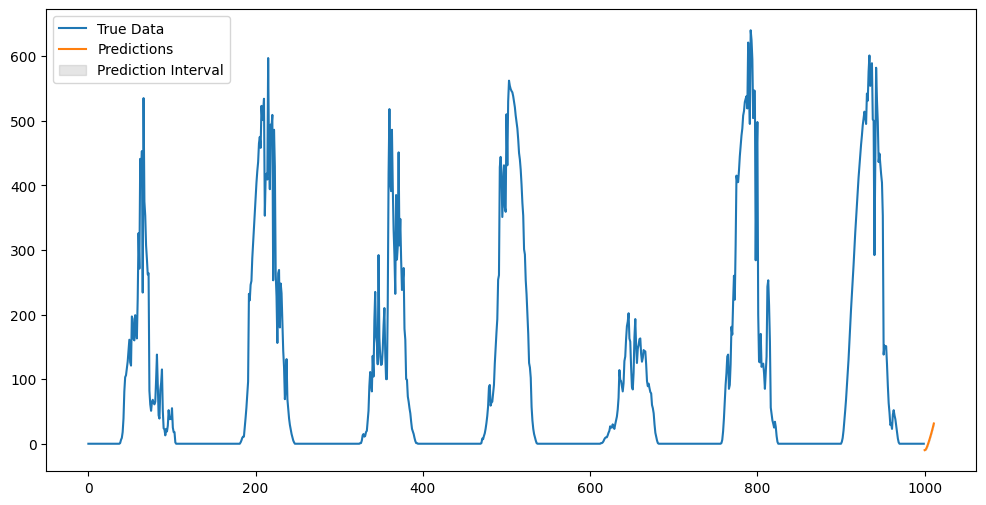

In [4]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.values)

def create_sequences(data, input_length, output_length):
    xs, ys = [], []
    for i in range(len(data) - input_length - output_length + 1):
        x = data[i:i+input_length]
        y = data[i+input_length:i+input_length+output_length]
        xs.append(x)
        ys.append(y[:, 0])
    return xs, ys

input_length = 24 * 6  # 24 hours of data with 10-minute intervals
output_length = 1  # Predicting one point at a time
hidden_size = 100 # Number of memory cells in one LSTM layer
num_layers = 3 # Number of LSTM layers
num_epochs = 100
learning_rate = 0.001

X, y = create_sequences(data_scaled, input_length, output_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_padded = pad_sequence([torch.tensor(x, dtype=torch.float32) for x in X_train], batch_first=True)
y_train_padded = pad_sequence([torch.tensor(y, dtype=torch.float32) for y in y_train], batch_first=True)
X_test_padded = pad_sequence([torch.tensor(x, dtype=torch.float32) for x in X_test], batch_first=True)
y_test_padded = pad_sequence([torch.tensor(y, dtype=torch.float32) for y in y_test], batch_first=True)
train_lengths = torch.tensor([len(x) for x in X_train], dtype=torch.int64)
test_lengths = torch.tensor([len(x) for x in X_test], dtype=torch.int64)

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size # Number of memory cells in one LSTM layer
        self.num_layers = num_layers # Number of LSTM layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x, lengths):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        packed_input = pack_padded_sequence(x, lengths.cpu(), batch_first=True, enforce_sorted=False)
        packed_output, (hn, cn) = self.lstm(packed_input, (h0, c0))
        out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        out = self.fc(out[range(len(out)), lengths-1])
        return out
    
model1_1 = LSTMModel(input_size=X_train_padded.shape[2], hidden_size=hidden_size, num_layers=num_layers, output_size=output_length)
model1_1 = model1_1.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1_1.parameters(), lr=learning_rate)
for epoch in range(num_epochs):
    model1_1.train()
    outputs = model1_1(X_train_padded.to(device), train_lengths)
    optimizer.zero_grad()
    loss = criterion(outputs, y_train_padded.to(device))
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
def rolling_predictions(model, data, input_length, output_points):
    model.eval()
    predictions = []
    current_seq = data[-input_length:, :]  # Initialize with the last input_length data points

    for _ in range(output_points):
        current_seq_tensor = torch.tensor(current_seq, dtype=torch.float32).unsqueeze(0).to(device)
        current_length = torch.tensor([len(current_seq)], dtype=torch.int64).cpu()
        pred = model(current_seq_tensor, current_length)
        pred = pred.detach().cpu().numpy().flatten()
        predictions.append(pred)

        next_seq = np.vstack((current_seq[1:], np.tile(pred, (current_seq.shape[1], 1)).T))
        current_seq = next_seq

    return np.array(predictions)
preds = rolling_predictions(model1_1, data_scaled, input_length=input_length, output_points=12)
preds = preds.flatten()
preds_rescaled = scaler.inverse_transform(np.hstack([preds.reshape(-1, 1)] * data.shape[1]))[:, 0]
# Calculate residuals on the training set
model1_1.eval()
train_preds = model1_1(X_train_padded.to(device), train_lengths)
train_preds = train_preds.detach().cpu().numpy().flatten()
train_residuals = y_train_padded.numpy().flatten() - train_preds

# Calculate the standard deviation of the residuals
std_dev = np.std(train_residuals)

# Calculate prediction intervals
pred_intervals = np.vstack([preds_rescaled - std_dev, preds_rescaled + std_dev]).T
plt.figure(figsize=(12, 6))
plt.plot(range(len(data_scaled)), scaler.inverse_transform(data_scaled)[:, 0], label='True Data')
plt.plot(range(len(data_scaled), len(data_scaled) + len(preds_rescaled)), preds_rescaled, label='Predictions')
plt.fill_between(range(len(data_scaled), len(data_scaled) + len(preds_rescaled)), 
                 pred_intervals[:, 0], pred_intervals[:, 1], color='gray', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.show()
# preds_rescaled[preds_rescaled < -1] = -1
# preds_rescaled

Below you can see the plots for dynamic testing. The trained model is the same 

In [ ]:
# Plot the 4 plots with new test data

### 2.1.2 CNN-LSTM

In [6]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('data_all.csv', parse_dates=['# DTG'])

# Select relevant features
features = ['Q_GLOB_10', 'SQ_10', 'Hour', 'DayOfWeek', 'Month', 'Minute']
data = data[features]

# Handle missing values if any
data = data.fillna(0)

# Scaling the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, input_length):
    xs, ys = [], []
    for i in range(len(data) - input_length):
        x = data[i:i+input_length]
        y = data[i+input_length, 0]  # Predicting 'Q_GLOB_10'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_length = 24 * 6  # 24 hours of data with 10-minute intervals
X, y = create_sequences(data_scaled, input_length)

# Split into train and test sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the CNN-LSTM model
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, conv_filters, kernel_size, lstm_hidden_size, lstm_layers, output_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=conv_filters, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, output_size)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = torch.relu(x)
        x = x.permute(0, 2, 1)  # Change the dimension to (batch_size, seq_length, num_features)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

input_size = X_train.shape[2]
conv_filters = 64
kernel_size = 3
lstm_hidden_size = 100
lstm_layers = 2
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model1_2 = CNNLSTMModel(input_size, conv_filters, kernel_size, lstm_hidden_size, lstm_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model1_2.parameters(), lr=0.001)

num_epochs = 100
batch_size = 64

# Training loop
for epoch in range(num_epochs):
    model1_2.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].to(device)
        
        outputs = model1_2(X_batch.permute(0, 2, 1))
        loss = criterion(outputs.squeeze(), y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Rolling predictions function
def rolling_predictions(model, data, input_length, output_points):
    model.eval()
    predictions = []
    current_seq = data[-input_length:, :]  # Start with the last input_length data points

    for _ in range(output_points):
        current_seq_tensor = torch.tensor(current_seq, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(current_seq_tensor.permute(0, 2, 1))
        pred = pred.cpu().numpy().flatten()
        predictions.append(pred)
        
        # Append the prediction to the sequence and remove the oldest data point
        next_seq = np.hstack((pred, current_seq[0, 1:]))
        current_seq = np.vstack((current_seq[1:], next_seq))

    return np.array(predictions)

output_points = 12
preds = rolling_predictions(model1_2, data_scaled, input_length, output_points)
preds_rescaled = scaler.inverse_transform(np.hstack([preds.reshape(-1, 1), np.zeros((preds.shape[0], data_scaled.shape[1] - 1))]))[:, 0]

# Calculate residuals on the training set
model1_2.eval()
train_preds = []
train_lengths = []

with torch.no_grad():
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        outputs = model1_2(X_batch.permute(0, 2, 1))
        train_preds.extend(outputs.cpu().numpy().flatten())

train_preds = np.array(train_preds)
train_residuals = y_train.numpy()[:len(train_preds)] - train_preds

# Calculate the standard deviation of the residuals
std_dev = np.std(train_residuals)

# Calculate prediction intervals for each predicted value
pred_intervals = np.vstack([preds_rescaled - std_dev, preds_rescaled + std_dev]).T

# Plotting the results
plt.figure(figsize=(12, 6))
dates = pd.date_range(start=data['# DTG'].iloc[-len(preds_rescaled)], periods=len(preds_rescaled), freq='10T')  # Adjusting dates for predictions
plt.plot(data['# DTG'], data['Q_GLOB_10'], label='True Data')
plt.plot(dates, preds_rescaled, label='Predictions', color='orange')
plt.fill_between(dates, pred_intervals[:, 0], pred_intervals[:, 1], color='gray', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Q_GLOB_10')
plt.title('Solar Irradiance Prediction with CNN-LSTM and Rolling Window')
plt.show()


Epoch [10/100], Loss: 0.0010
Epoch [20/100], Loss: 0.0002
Epoch [30/100], Loss: 0.0002
Epoch [40/100], Loss: 0.0003
Epoch [50/100], Loss: 0.0012
Epoch [60/100], Loss: 0.0002
Epoch [70/100], Loss: 0.0005
Epoch [80/100], Loss: 0.0007
Epoch [90/100], Loss: 0.0025
Epoch [100/100], Loss: 0.0000


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.


KeyError: '# DTG'

<Figure size 1200x600 with 0 Axes>

## 2.2 Multi-feature model
- Solar irradiance
- Sunshine duration
- ...

This utilises the dataset from above, while concatenating it with another dataset `vorigemaand.txt` from [KNMI][4] for the penultimate month.

[4]: https://www.knmi.nl/nederland-nu/klimatologie/daggegevens

In [7]:
data_all = pd.read_csv("data_all.csv")
data_all

,# DTG,LOCATION_x,NAME_x,LATITUDE_x,LONGITUDE_x,ALTITUDE_x,H_LAYER_10,H1_LAYER_10,H2_LAYER_10,H3_LAYER_10,...,NH_CEILOM_10,NAME_y,Q_GLOB_10,QN_GLOB_10,QX_GLOB_10,SQ_10,Hour,DayOfWeek,Month,Minute
0,2024-04-01 00:10:00,215_S_a,Voorschoten ceilometer,52.139722,4.436389,-1.1,5434.92,5434.92,21424.90,0.00,...,NaN,Voorschoten stralingsmeter,0.0,0.0,0.0,0.0,0,0,4,10
1,2024-04-01 00:20:00,215_S_a,Voorschoten ceilometer,52.139722,4.436389,-1.1,5434.92,5434.92,20884.90,0.00,...,NaN,Voorschoten stralingsmeter,0.0,0.0,0.0,0.0,0,0,4,20
2,2024-04-01 00:30:00,215_S_a,Voorschoten ceilometer,52.139722,4.436389,-1.1,2854.92,2854.92,5434.92,20904.90,...,NaN,Voorschoten stralingsmeter,0.0,0.0,0.0,0.0,0,0,4,30
3,2024-04-01 00:40:00,215_S_a,Voorschoten ceilometer,52.139722,4.436389,-1.1,2784.92,2784.92,4004.92,4654.92,...,NaN,Voorschoten stralingsmeter,0.0,0.0,1.0,0.0,0,0,4,40
4,2024-04-01 00:50:00,215_S_a,Voorschoten ceilometer,52.139722,4.436389,-1.1,1644.92,1644.92,2844.92,4614.92,...,NaN,Voorschoten stralingsmeter,0.0,0.0,1.0,0.0,0,0,4,50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4315,2024-04-30 23:20:00,215_S_a,Voorschoten ceilometer,52.139722,4.436389,-1.1,7154.92,7154.92,0.00,0.00,...,NaN,Voorschoten stralingsmeter,0.0,0.0,0.0,0.0,23,1,4,20
4316,2024-04-30 23:30:00,215_S_a,Voorschoten ceilometer,52.139722,4.436389,-1.1,7104.92,7104.92,0.00,0.00,...,NaN,Voorschoten stralingsmeter,0.0,0.0,0.0,0.0,23,1,4,30
4317,2024-04-30 23:40:00,215_S_a,Voorschoten ceilometer,52.139722,4.436389,-1.1,6554.92,6554.92,0.00,0.00,...,NaN,Voorschoten stralingsmeter,0.0,0.0,0.0,0.0,23,1,4,40
4318,2024-04-30 23:50:00,215_S_a,Voorschoten ceilometer,52.139722,4.436389,-1.1,6344.92,6344.92,0.00,0.00,...,NaN,Voorschoten stralingsmeter,0.0,0.0,0.0,0.0,23,1,4,50


In [9]:
data_all.columns

Index(['# DTG', 'LOCATION_x', 'NAME_x', 'LATITUDE_x', 'LONGITUDE_x',
       'ALTITUDE_x', 'H_LAYER_10', 'H1_LAYER_10', 'H2_LAYER_10', 'H3_LAYER_10',
       'H_CEILOM_10', 'H1_CEILOM_10', 'H2_CEILOM_10', 'H3_CEILOM_10',
       'N_LAYER_10', 'N1_LAYER_10', 'N2_LAYER_10', 'N3_LAYER_10',
       'N_CEILOM_10', 'N1_CEILOM_10', 'N2_CEILOM_10', 'N3_CEILOM_10',
       'NH_CEILOM_10', 'NAME_y', 'Q_GLOB_10', 'QN_GLOB_10', 'QX_GLOB_10',
       'SQ_10', 'Hour', 'DayOfWeek', 'Month', 'Minute'],
      dtype='object')

All data has 

### 2.2.1 LSTM

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Scaling the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.values)

# Function to create sequences
def create_sequences(data, input_length):
    xs, ys = [], []
    for i in range(len(data) - input_length):
        x = data[i:i+input_length]
        y = data[i+input_length, 0]  # Predicting the 'Q' value
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_length = 24 * 6  # 24 hours of data with 10-minute intervals
X, y = create_sequences(data_scaled, input_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

input_size = X_train.shape[2]
hidden_size = 100
num_layers = 3
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2_1 = LSTMModel(input_size, hidden_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2_1.parameters(), lr=0.001)

num_epochs = 100
batch_size = 64

# Training loop
for epoch in range(num_epochs):
    model2_1.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].to(device)
        
        outputs = model2_1(X_batch)
        loss = criterion(outputs.squeeze(), y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Rolling predictions function
def rolling_predictions(model, data, input_length, output_points):
    model.eval()
    predictions = []
    current_seq = data[-input_length:, :]  # Start with the last input_length data points

    for _ in range(output_points):
        current_seq_tensor = torch.tensor(current_seq, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(current_seq_tensor)
        pred = pred.cpu().numpy().flatten()
        predictions.append(pred)
        
        # Append the prediction to the sequence and remove the oldest data point
        next_seq = np.hstack((pred, current_seq[0, 1:]))
        current_seq = np.vstack((current_seq[1:], next_seq))

    return np.array(predictions)

output_points = 12
preds = rolling_predictions(model2_1, data_scaled, input_length, output_points)
preds_rescaled = scaler.inverse_transform(np.hstack([preds.reshape(-1, 1), np.zeros((preds.shape[0], data_scaled.shape[1] - 1))]))[:, 0]

# Calculate residuals on the training set
model2_1.eval()
train_preds = []
train_lengths = []

with torch.no_grad():
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        outputs = model2_1(X_batch)
        train_preds.extend(outputs.cpu().numpy().flatten())

train_preds = np.array(train_preds)
train_residuals = y_train.numpy()[:len(train_preds)] - train_preds

# Calculate the standard deviation of the residuals
std_dev = np.std(train_residuals)

# Calculate prediction intervals for each predicted value
pred_intervals = np.vstack([preds_rescaled - std_dev, preds_rescaled + std_dev]).T

# Plotting the results
plt.figure(figsize=(12, 6))
dates = pd.date_range(start='1/1/2020', periods=len(data), freq='10T')  # Example date range
plt.plot(dates, data['Q'], label='True Data')
plt.plot(dates[-len(preds_rescaled):], preds_rescaled, label='Predictions')
plt.fill_between(dates[-len(preds_rescaled):], pred_intervals[:, 0], pred_intervals[:, 1], color='gray', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Solar Irradiance (Q)')
plt.title('Solar Irradiance Prediction with LSTM and Prediction Intervals')
plt.show()


### 2.2.2 CNN-LSTM

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('data_all.csv', parse_dates=['# DTG'])

# Select relevant features
features = ['Q_GLOB_10', 'SQ_10', 'Hour', 'DayOfWeek', 'Month', 'Minute']
data = data[features]

# Handle missing values if any
data = data.fillna(0)

# Scaling the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, input_length):
    xs, ys = [], []
    for i in range(len(data) - input_length):
        x = data[i:i+input_length]
        y = data[i+input_length, 0]  # Predicting 'Q_GLOB_10'
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

input_length = 24 * 6  # 24 hours of data with 10-minute intervals
X, y = create_sequences(data_scaled, input_length)

# Split into train and test sets
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Define the CNN-LSTM model
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, conv_filters, kernel_size, lstm_hidden_size, lstm_layers, output_size):
        super(CNNLSTMModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=conv_filters, kernel_size=kernel_size)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.lstm = nn.LSTM(input_size=conv_filters, hidden_size=lstm_hidden_size, num_layers=lstm_layers, batch_first=True)
        self.fc = nn.Linear(lstm_hidden_size, output_size)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = torch.relu(x)
        x = x.permute(0, 2, 1)  # Change the dimension to (batch_size, seq_length, num_features)
        x, _ = self.lstm(x)
        x = self.fc(x[:, -1, :])
        return x

input_size = X_train.shape[2]
conv_filters = 64
kernel_size = 3
lstm_hidden_size = 100
lstm_layers = 2
output_size = 1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model2_2 = CNNLSTMModel(input_size, conv_filters, kernel_size, lstm_hidden_size, lstm_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model2_2.parameters(), lr=0.001)

num_epochs = 100
batch_size = 64

# Training loop
for epoch in range(num_epochs):
    model2_2.train()
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        y_batch = y_train[i:i+batch_size].to(device)
        
        outputs = model2_2(X_batch.permute(0, 2, 1))
        loss = criterion(outputs.squeeze(), y_batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Rolling predictions function
def rolling_predictions(model, data, input_length, output_points):
    model.eval()
    predictions = []
    current_seq = data[-input_length:, :]  # Start with the last input_length data points

    for _ in range(output_points):
        current_seq_tensor = torch.tensor(current_seq, dtype=torch.float32).unsqueeze(0).to(device)
        with torch.no_grad():
            pred = model(current_seq_tensor.permute(0, 2, 1))
        pred = pred.cpu().numpy().flatten()
        predictions.append(pred)
        
        # Append the prediction to the sequence and remove the oldest data point
        next_seq = np.hstack((pred, current_seq[0, 1:]))
        current_seq = np.vstack((current_seq[1:], next_seq))

    return np.array(predictions)

output_points = 12
preds = rolling_predictions(model2_2, data_scaled, input_length, output_points)
preds_rescaled = scaler.inverse_transform(np.hstack([preds.reshape(-1, 1), np.zeros((preds.shape[0], data_scaled.shape[1] - 1))]))[:, 0]

# Calculate residuals on the training set
model2_2.eval()
train_preds = []
train_lengths = []

with torch.no_grad():
    for i in range(0, len(X_train), batch_size):
        X_batch = X_train[i:i+batch_size].to(device)
        outputs = model2_2(X_batch.permute(0, 2, 1))
        train_preds.extend(outputs.cpu().numpy().flatten())

train_preds = np.array(train_preds)
train_residuals = y_train.numpy()[:len(train_preds)] - train_preds

# Calculate the standard deviation of the residuals
std_dev = np.std(train_residuals)

# Calculate prediction intervals for each predicted value
pred_intervals = np.vstack([preds_rescaled - std_dev, preds_rescaled + std_dev]).T

# Plotting the results
plt.figure(figsize=(12, 6))
dates = pd.date_range(start=data['# DTG'].iloc[-len(preds_rescaled)], periods=len(preds_rescaled), freq='10T')  # Adjusting dates for predictions
plt.plot(data['# DTG'], data['Q_GLOB_10'], label='True Data')
plt.plot(dates, preds_rescaled, label='Predictions', color='orange')
plt.fill_between(dates, pred_intervals[:, 0], pred_intervals[:, 1], color='gray', alpha=0.2, label='Prediction Interval')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Q_GLOB_10')
plt.title('Solar Irradiance Prediction with CNN-LSTM and Rolling Window')
plt.show()


# Further Refinements

To make the training and model more efficient, algorithm based feature selection could be used. 

Publicly available alternative models for solar irradiance forecasting (that were tested and working) are following:
- Time Series Forecasting of Solar Irradiance by [Gautam][a].
- Solar Irradiance Forecasting with Transformer Model by [Kubovčik][b_1], and the respective research paper by [Pospichal _et al._ 2022][b_2].
- Irradiance RNN by [DiMaggio][c], based on the paper by [Alzahrani _et al._ 2017][c_2]. 
- Solar Prediction by [Wang][d].

[a]: https://github.com/sgautam666/Time_Series_Forecasting_of_Solar_Irradiance
[b_1]: https://github.com/markub3327/Solar-Transformer
[b_2]: https://www.mdpi.com/2076-3417/12/17/8852
[c_1]: https://github.com/antoninodimaggio/Irradiance-RNN
[c_2]: https://www.sciencedirect.com/science/article/pii/S1877050917318392
[d]: https://github.com/Kejie-Wang/SolarPrediction

# TO DO:
- save the models (all 4)
- 4 or 5 plots per model with rolling window outputs - 5 times 5 different test sets +1, +1, +1, +1, +1